In [2]:
import torch
import numpy as np
import cv2
from transformers import pipeline
from diffusers.utils import load_image, make_image_grid
from diffusers import UniPCMultistepScheduler
from pipeline_controlnet_sync import StableDiffusionControlNetPipeline
from controlnet_sync import ControlNetModelSync
from omegaconf import OmegaConf

from SyncDreamer.ldm.util import instantiate_from_config, prepare_inputs

def load_model(cfg,ckpt,strict=True):
    config = OmegaConf.load(cfg)
    model = instantiate_from_config(config.model)
    print(f'loading model from {ckpt} ...')
    ckpt = torch.load(ckpt,map_location='cuda')
    model.load_state_dict(ckpt['state_dict'],strict=strict)
    model = model.cuda().eval()
    return model

# pretrain_path = '/home/jupyter/diffusers/examples/controlnet/models_syncdreamer/'
pretrain_path = '/home/jupyter/diffusers/examples/controlnet/models_syncdreamer3/checkpoint-3000/controlnet/'
controlnet = ControlNetModelSync.from_pretrained(pretrain_path, torch_dtype=torch.float32, use_safetensors=True)
controlnet.to('cuda', dtype=torch.float32)
cfg = 'SyncDreamer/configs/syncdreamer.yaml'
dreamer = load_model(cfg, 'SyncDreamer/ckpt/syncdreamer-pretrain.ckpt', strict=True)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Selected timesteps for ddim sampler: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196 201 206 211 216 221 226 231 236 241 246 251 256 261 266
 271 276 281 286 291 296 301 306 311 316 321 326 331 336 341 346 351 356
 361 366 371 376 381 386 391 396 401 406 411 416 421 426 431 436 441 446
 451 456 461 466 471 476 481 486 491 496 501 506 511 516 521 526 531 536
 541 546 551 556 561 566 571 576 581 586 591 596 601 606 611 616 621 626
 631 636 641 646 651 656 661 666 671 676 681 686 691 696 701 706 711 716
 721 726 731 736 741 746 751 756 761 766 771 776 781 786 791 796 801 806
 811 816 821 826 831 836 841 846 851 856 861 866 871 876 881 886 891 896
 901 906 911 916 921 926 931 936 941 946 951 956 961 966 971 97

In [3]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    controlnet=controlnet, dreamer=dreamer, torch_dtype=torch.float32, use_safetensors=True
)

pipe.to('cuda', dtype=torch.float32)
print()

In [ ]:
import os
test_imgs = ['aircraft.png','alarm.png','armor.png','backpack.png','box.png','bread.png','bucket.png','busket.png','cargo.png','cat.png','chili.png','crab.png','crystal.png','deer.png','drum.png','drum2.png','elephant.png','flower.png','flower2.png','forest.png','giraffe.png','grandfather.png','ground.png','halloween.png','hat.png','head.png','house.png','kettle.png','kunkun.png','lantern.png','lotus_seed.png','lunch_bag.png','milk.png','monkey.png','oil.png','poro.png','school_bus1.png','school_bus2.png','shed.png','shoe.png','sofa.png','sofa2.png','steak.png','teapot.png','teapot2.png','toaster.png','turtle.png','vase.png','wisky.png']

In [7]:
! pip install wheel

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


[[78, 64], [238, 64], [238, 256], [78, 256], [78, 64]]


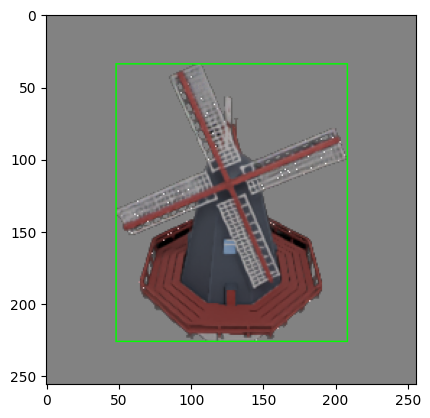

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


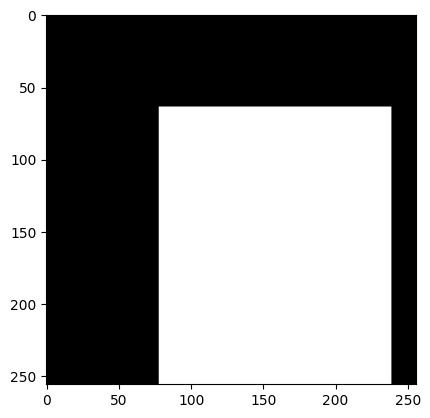

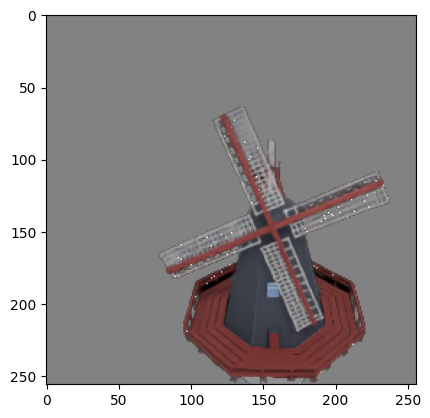

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import torch
import sys

def get_bounding_box_not_equal_color(image_input, target_color, tolerance=30, x_offset=0, y_offset=0):
    # Read the image
    # image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    # image_rgb = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
    image_rgb = image_input

    # Define lower and upper bounds for the target color
    lower_bound = np.array(target_color) - tolerance
    upper_bound = np.array(target_color) + tolerance

    # Create a mask for pixels not within the specified color range
    mask = 255 - cv2.inRange(image_rgb, lower_bound, upper_bound)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes for areas with colors not equal to the target color
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    # Draw bounding boxes on the original image
    xmin, ymin, xmax, ymax = 256, 256, 0, 0
    for bbox in bounding_boxes:
        # print(bbox)
        x, y, w, h = bbox
        xmin = min(xmin, x)
        ymin = min(ymin, y)
        xmax = max(xmax, x + w)
        ymax = max(ymax, y + h)
    # plt.imshow(image_rgb)
    # plt.show()
    image_foreground = image_rgb[ymin:ymax, xmin:xmax, :]
    image_rgb = cv2.UMat(image_rgb)
    cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    image_rgb = cv2.UMat.get(image_rgb)
    
    mask_data = np.zeros((256, 256, 3))
    xmin = max(0, min(xmin + x_offset, 256))
    ymin = max(0, min(ymin + y_offset, 256))
    xmax = min(256, max(xmax + x_offset, 0))
    ymax = min(256, max(ymax + y_offset, 0))
    
    target_image = np.full(image_input.shape, target_color, dtype=np.uint8)
    target_image[ymin:ymax, xmin:xmax, :] = image_foreground
        
    bbox = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    bbox = bbox + [bbox[0]]
    print(bbox)
    cv2.fillPoly(mask_data, [np.array(bbox)], color=(255,255,255))
    # cv2.imwrite(condition_path, mask_data)
    
    # Display the result
    plt.imshow(image_rgb)
    plt.show()
    plt.imshow(mask_data)
    plt.show()
    plt.imshow(target_image)
    plt.show()

def add_margin(pil_img, color=0, size=256):
    width, height = pil_img.size
    result = Image.new(pil_img.mode, (size, size), color)
    result.paste(pil_img, ((size - width) // 2, (size - height) // 2))
    return result

# Replace 'your_image_path.jpg' with the actual path to your image file
# Replace 'target_color' with the RGB values of the color you want to exclude
image_size = 256
# img_name = '01ef5233779b474983a4c1f552107a45_000_y_-0.2.png'
img_name = '01ef5233779b474983a4c1f552107a45_000.png'
input_path = 'testset/' + img_name
output_path = 'preprocessed/' + img_name

x_offset = 30 #horizontal
y_offset = 30 #vertical

# subprocess.run([sys.executable, 'foreground_segment.py', '--input', input_path, '--output', output_path])

image_input = Image.open(output_path)
condition_path = 'condition/' + img_name

image_input = add_margin(image_input, size=max(image_input.height, image_input.width))
image_input = image_input.resize((image_size, image_size), resample=Image.BICUBIC)
image_input = np.array(image_input)[:,:,:3].reshape(image_input.size[1], image_input.size[0], 3)
background_color = image_input[0,0,:]

get_bounding_box_not_equal_color(image_input, target_color=background_color, tolerance=30, x_offset=x_offset, y_offset=y_offset)

In [5]:
mask_data = np.zeros((256, 256, 3))
cv2.imwrite('condition/01ef5233779b474983a4c1f552107a45_000_y_-0.5.png', mask_data)

True

In [ ]:
import PIL

import cv2
import os
import matplotlib.pyplot as plt

def display_imgs(imgs, titles, w, h):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(40,40))
    for i in range(len(imgs)):
        ax = fig.add_subplot(h,w,i + 1)
        # ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(imgs[i],None)
    plt.tight_layout()
    plt.axis('off')
    plt.grid(False)
    plt.show()
        
w = 16
h = 1

# for test_img in test_imgs:
for test_img in ['01ef5233779b474983a4c1f552107a45_000_y_-0.2.png']:
# for test_img in ['backpack.png']:
    # input_image_path = 'testset/' + test_img
    input_image_path = test_img
    conditioning_image_path = 'condition/' + test_img
    output = pipe(conditioning_image_path=conditioning_image_path, input_image_path=input_image_path)
    
    titles = []
    imgs = []
    for i in range(16):
        imgs.append(output[i])
        titles.append(str(i * 22.5) + ' degrees')
    display_imgs(imgs, titles, w, h)

Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/envs/controlnet/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
DDIM Sampler: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


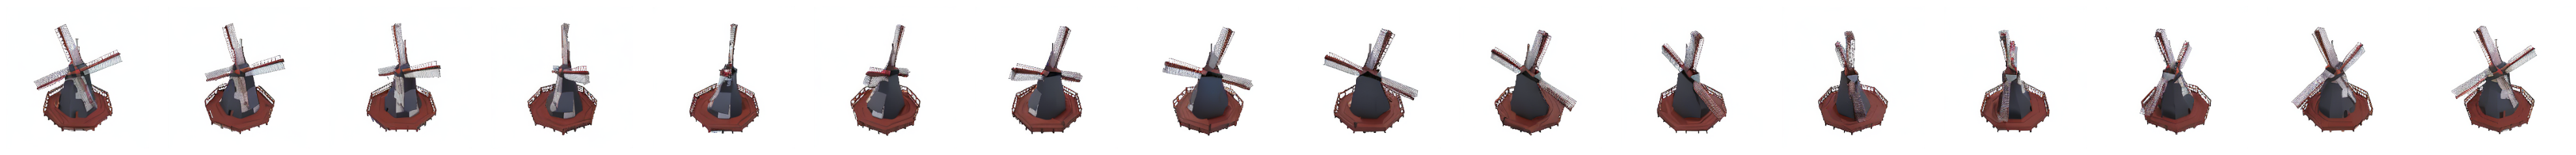

In [4]:
import PIL

import cv2
import os
import matplotlib.pyplot as plt

def display_imgs(imgs, titles, w, h):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(40,40))
    for i in range(len(imgs)):
        ax = fig.add_subplot(h,w,i + 1)
        # ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(imgs[i],None)
    plt.tight_layout()
    plt.axis('off')
    plt.grid(False)
    plt.show()
        
w = 16
h = 1

# for test_img in test_imgs:
# for test_img in ['01ef5233779b474983a4c1f552107a45_000_y_-0.5.png']:
for test_img in ['testset/01ef5233779b474983a4c1f552107a45_000.png']:
# for test_img in ['backpack.png']:
    # input_image_path = 'testset/' + test_img
    input_image_path = test_img
    # conditioning_image_path = 'condition/' + test_img
    conditioning_image_path = '01ef5233779b474983a4c1f552107a45_000_y_-0.2.png'
    output = pipe(conditioning_image_path=conditioning_image_path, input_image_path=input_image_path)
    
    titles = []
    imgs = []
    for i in range(16):
        imgs.append(output[i])
        titles.append(str(i * 22.5) + ' degrees')
    display_imgs(imgs, titles, w, h)

In [ ]:
import cv2
import matplotlib.pyplot as plt

test_img = '01ef5233779b474983a4c1f552107a45_000.png'
target_img = cv2.imread('/home/jupyter/data/controlnet_syncdreamer/target_images/' + test_img)
plt.imshow(target_img)
plt.show()
conditioning_image_path = 'condition/' + test_img
condition_img = cv2.imread(conditioning_image_path)
plt.imshow(condition_img)
plt.show()

In [ ]:
# move training data together
import os
import shutil

path = '/home/jupyter/data/controlnet_syncdreamer/'
path1 = '/home/jupyter/data/controlnet_syncdreamer1/'
path2 = '/home/jupyter/data/controlnet_syncdreamer2/'

folders = ['conditioning_images', 'input_images', 'target_images']

for folder in folders:
    for file in os.listdir(os.path.join(path2, folder)):
        src = os.path.join(path2, folder, file)
        dst = os.path.join(path, folder, file)
        shutil.copy(src, dst)

In [ ]:
# move training data together
import os
import shutil

path = '/home/jupyter/data/controlnet_syncdreamer/'
path1 = '/home/jupyter/data/controlnet_syncdreamer1/'
path2 = '/home/jupyter/data/controlnet_syncdreamer2/'

folders = ['conditioning_images', 'input_images', 'target_images']

for folder in folders:
    for file in os.listdir(os.path.join(path1, folder)):
        src = os.path.join(path1, folder, file)
        dst = os.path.join(path, folder, file)
        shutil.copy(src, dst)

In [ ]:
len(os.listdir(path + 'input_images'))

In [ ]:
def display_imgs(imgs, titles, w, h):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(40,40))
    for i in range(len(imgs)):
        ax = fig.add_subplot(h,w,i + 1)
        # ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(imgs[i],None)
    plt.tight_layout()
    plt.axis('off')
    plt.grid(False)
    plt.show()
        
w = 16
h = 1


data_dir = '/home/jupyter/data/controlnet_syncdreamer/'
uids = os.listdir(os.path.join(data_dir, 'input_images'))[:10]
input_dir = os.path.join(data_dir, 'input_images')
condition_dir = os.path.join(data_dir, 'conditioning_images')
target_dir = os.path.join(data_dir, 'target_images')
# data integrity check

for uid in uids:
    # get current uid
    uid = uid.split('.png')[0][:-4]
    # get conditioning images
    conditions = []
    targets = []
    input = cv2.imread(os.path.join(input_dir, uid + '_' + str(0).zfill(3) + '.png'))
    plt.imshow(input)
    plt.show()
    for i in range(16):
        condition = cv2.imread(os.path.join(condition_dir, uid + '_' + str(i).zfill(3) + '.png'))
        conditions.append(condition)
        target = cv2.imread(os.path.join(target_dir, uid + '_' + str(i).zfill(3) + '.png'))
        targets.append(target)
    display_imgs(conditions, [], w, h)
    display_imgs(targets, [], w, h)

In [ ]:
with open('/home/jupyter/data/controlnet_syncdreamer/train_raw.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

eval(lines[7])

In [ ]:
# modify train.jsonl: change input image to be the first target image, models_syncdreamer2
# use the first condition image as the condition iamge
with open('/home/jupyter/data/controlnet_syncdreamer/train_raw.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

with open('/home/jupyter/data/controlnet_syncdreamer/train.jsonl', 'w') as file:
    for line in lines:
        line = eval(line[:-1])
        line['input_image'] = eval(line['target_images'])[0]
        line['conditioning_image'] = line['conditioning_image'].split('.png')[0][:-3] + '000.png'

        line = '"image": "{}", "input_image": "{}", "conditioning_image": "{}", "target_index":{}, "target_images": "{}", "y_offset": "{}", "z_offset": "{}"'.format(line['image'], line['input_image'], line['conditioning_image'], line['target_index'], line['target_images'], line['y_offset'], line['z_offset'])
        line = '{' + line + '}\n'
        file.write(line)
file.close()

In [ ]:
with open('/home/jupyter/data/controlnet_syncdreamer/train.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

line = eval(lines[12])
line

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

data_dir = '/home/jupyter/data/controlnet_syncdreamer/'
input_image = cv2.imread(os.path.join(data_dir, line['input_image']))
conditioning_image = cv2.imread(os.path.join(data_dir, line['conditioning_image']))
plt.imshow(input_image)
plt.show()
plt.imshow(conditioning_image)
plt.show()

for f in eval(line['target_images']):
    target_image = cv2.imread(os.path.join(data_dir, f))
    plt.imshow(target_image)
    plt.show()

In [7]:
with open('/home/jupyter/data/controlnet_syncdreamer/train_raw.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

In [9]:
eval(lines[12][:-1])

{'image': 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_012.png',
 'input_image': 'input_images/5b2a1bbfe9c441859d771dafa3f6c3ad_000.png',
 'conditioning_image': 'conditioning_images/5b2a1bbfe9c441859d771dafa3f6c3ad_012.png',
 'target_index': 12,
 'target_images': "['target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_000.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_001.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_002.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_003.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_004.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_005.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_006.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_007.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_008.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_009.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_010.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_011.png', 'target_images/5b2a1bbfe9c441859d77

In [10]:
# modify train.jsonl: change input image to be the input image, models_syncdreamer3
# use the first target image as the condition iamge, input image as input image
with open('/home/jupyter/data/controlnet_syncdreamer/train_raw.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

with open('/home/jupyter/data/controlnet_syncdreamer/train.jsonl', 'w') as file:
    for line in lines:
        line = eval(line[:-1])
        line['input_image'] = line['input_image']
        line['conditioning_image'] = eval(line['target_images'])[0]

        line = '"image": "{}", "input_image": "{}", "conditioning_image": "{}", "target_index":{}, "target_images": "{}", "y_offset": "{}", "z_offset": "{}"'.format(line['image'], line['input_image'], line['conditioning_image'], line['target_index'], line['target_images'], line['y_offset'], line['z_offset'])
        line = '{' + line + '}\n'
        file.write(line)
file.close()

In [12]:
with open('/home/jupyter/data/controlnet_syncdreamer/train.jsonl', 'r') as file:
    lines = file.readlines()
file.close()

eval(lines[12][:-1])

{'image': 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_012.png',
 'input_image': 'input_images/5b2a1bbfe9c441859d771dafa3f6c3ad_000.png',
 'conditioning_image': 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_000.png',
 'target_index': 12,
 'target_images': "['target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_000.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_001.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_002.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_003.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_004.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_005.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_006.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_007.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_008.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_009.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_010.png', 'target_images/5b2a1bbfe9c441859d771dafa3f6c3ad_011.png', 'target_images/5b2a1bbfe9c441859d771dafa3